In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import re
import string

In [2]:
# Install the font tools (only if not already installed)
!apt-get install -y fonts-liberation
!apt-get install -y fontconfig

# Copy the font to the Colab environment
!cp /content/drive/MyDrive/path/to/SolaimanLipi.ttf /usr/share/fonts/truetype/

# Rebuild the font cache
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-liberation is already the newest version (1:1.07.4-11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fontconfig is already the newest version (2.13.1-4.2ubuntu5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
cp: cannot stat '/content/drive/MyDrive/path/to/SolaimanLipi.ttf': No such file or directory
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/noto: caching, new cache contents: 80 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/shar

# Reading file

In [48]:


try:
  df = pd.read_csv('/content/final_bn_data.csv', encoding='utf-8')  # Try utf-8 first
except UnicodeDecodeError:
  try:
    df = pd.read_csv('/content/final_bn_data.csv', encoding='cp1252')  # Try cp1252
  except UnicodeDecodeError:
    df = pd.read_csv('/content/final_bn_data.csv', encoding='latin-1')  # Try latin-1
    print("Successfully loaded with 'latin-1' encoding")
  else:
    print("Successfully loaded with 'cp1252' encoding")
else:
  print("Successfully loaded with 'utf-8' encoding")

Successfully loaded with 'utf-8' encoding


# Data Description


In [4]:
df.head()

,category,headline,content,label
0,National,৮ দিনে ১৮ বিল পাস!,দশম জাতীয় সংসদের মেয়াদ শেষ হয়ে যাচ্ছে। কার্যত ...,0.0
1,Sports,আ’লীগের জনসভায় লোকে লোকারণ্য ফেনী ট্রাংক রোড,একাদশ জাতীয় সংসদ নির্বাচনকে সামনে রেখে সাংগঠনি...,0.0
2,National,মাদ্রাসায় জোড়া খুন: পরিচালক তিন দিনের রিমান্ডে,গাজীপুরে জোড়া খুন মামলার প্রধান আসামি মাদ্রাসা...,0.0
3,Sports,নেপালকে হারিয়ে গ্রুপ চ্যাম্পিয়ন বাংলাদেশ,সাফ অনূর্ধ্ব-১৮ নারী ফুটবল চ্যাম্পিয়নশিপে নেপা...,1.0
4,National,কুড়িগ্রামে ২ শিক্ষার্থীর লাশ উদ্ধার,কুড়িগ্রাম প্রতিনিধি : কুড়িগ্রাম সদর উপজেলার বে...,1.0


In [5]:
df.tail()

,category,headline,content,label
14532,National,নাইক্ষ্যংছ‌ড়ি‌তে পু‌লি‌শ-ডাকাত বন্দুকযু‌দ্ধে ন...,বান্দরবা‌নের নাইক্ষ্যংছ‌ড়ি উপজেলায় পু‌লি‌শের স...,0.0
14533,Crime,এবি ব্যাংকের প্রাক্তন চেয়ারম্যানসহ ৪ জনকে জিজ্...,নিজস্ব প্রতিবেদক : সিটিসেলের নামে ৩৮৩ কোটি টাক...,1.0
14534,Education,পরীক্ষা বাতিল হওয়ায় ১ম -৩য় শ্রেণীতে ভর্তি হতে ...,১-৩ শ্রেনী পর্যন্ত পরীক্ষা বাতিলের কথা শুনে দে...,0.0
14535,Sports,এশিয়া কাপে আজ ভারত-পাকিস্তানের মহারণ,আজ এশিয়া কাপের সবচেয়ে আকর্ষণীয় ম্যাচে ভারতের ম...,0.0
14536,Lifestyle,অনলাইনে পোশাক কিনলেই ছাড়,সমসাময়িক ট্রেন্ড এবং তারুণ্য নির্ভর ফ্যাশনে ক্...,1.0


In [49]:
df.shape

(14537, 4)

In [6]:
df.isnull().sum()


,0
category,0
headline,0
content,0
label,0


No Null values found


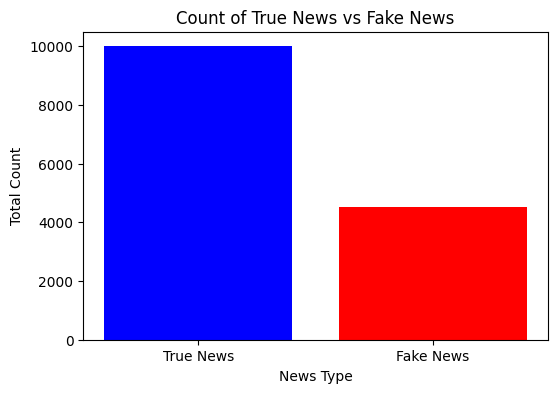

In [7]:
counts = df['label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(['True News', 'Fake News'], counts, color=['blue', 'red'])
plt.xlabel('News Type')
plt.ylabel('Total Count')
plt.title('Count of True News vs Fake News')
plt.show()

The dataset is Imbalanced


In [50]:
zero_label_count = df[df['label'] == 0].shape[0]
print("Total labeled data with label 0:", zero_label_count)

Total labeled data with label 0: 4537


In [51]:
one_label_count = df[df['label'] == 1].shape[0]
print("Total labeled data with label 1:", one_label_count)

Total labeled data with label 1: 10000


# Balancing the Dataset

In [10]:
import random


rows_to_drop =  (10000 - 4537)
print("Number of rows to drop:", rows_to_drop)


label_one_indices = df[df['label'] == 1].index


indices_to_drop = random.sample(list(label_one_indices), rows_to_drop)


df.drop(indices_to_drop, inplace=True)

# Print the updated counts to verify the changes
print("Total labeled data with label 0 after dropping:", df[df['label'] == 0].shape[0])
print("Total labeled data with label 1 after dropping:", df[df['label'] == 1].shape[0])


Number of rows to drop: 5463
Total labeled data with label 0 after dropping: 4537
Total labeled data with label 1 after dropping: 4537


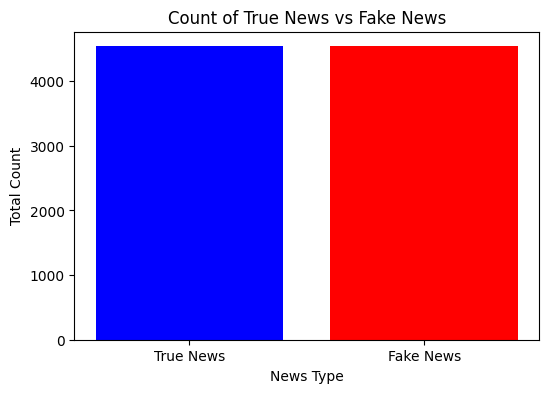

In [11]:
counts = df['label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(['True News', 'Fake News'], counts, color=['blue', 'red'])
plt.xlabel('News Type')
plt.ylabel('Total Count')
plt.title('Count of True News vs Fake News')
plt.show()

Now the Dataset is Balanced


In [12]:
df.reset_index( inplace=True)

# **Correcting** **sentences before  vectorization**


In [13]:
def wordopt(content):
  content = content.lower()
  content = re.sub('\[.*?\]', '', content)
  content = re.sub("\\W"," ",content)
  content = re.sub('https?://\S+|www\.\S+', '', content)
  content = re.sub('<.*?>+', '', content)
  content = re.sub('[%s]' % re.escape(string.punctuation), '', content)
  content = re.sub('\n', '', content)
  content = re.sub('\w*\d\w*', '', content)
  return content

In [14]:
df["content"] = df["content"].apply(wordopt)

In [15]:
x=df["content"]
y=df["label"]

In [16]:
x

,content
0,দশম জ ত য় স সদ র ম য় দ শ ষ হয় য চ ছ ক র যত ...
1,এক দশ জ ত য় স সদ ন র ব চনক স মন র খ স গঠন ...
2,গ জ প র জ ড় খ ন ম মল র প রধ ন আস ম ম দ র স ...
3,স ফ অন র ধ ব ন র ফ টবল চ য ম প য়নশ প ন প লক...
4,ক ড় গ র ম প রত ন ধ ক ড় গ র ম সদর উপজ ল র ব ...
...,...
9069,প থ ব র য ম য় ট আক শর জ র ব ড় ক জ কর ত র ন...
9070,ব ন দরব ন র ন ইক ষ য ছ ড় উপজ ল য় প ল শ র স...
9071,ন জস ব প রত ব দক স ট স ল র ন ম ক ট ট ক আ...
9072,শ র ন পর যন ত পর ক ষ ব ত ল র কথ শ ন দ শ ...


In [17]:
y

,label
0,0.0
1,0.0
2,0.0
3,1.0
4,1.0
...,...
9069,0.0
9070,0.0
9071,1.0
9072,0.0


# **Training and Testing**

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [19]:
x_train.shape

(6805,)

In [20]:
x_test.shape

(2269,)

In [21]:
vectorization = TfidfVectorizer()


In [22]:
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

In [23]:
xv_train

<6805x9720 sparse matrix of type '<class 'numpy.float64'>'
	with 620099 stored elements in Compressed Sparse Row format>

In [24]:
xv_test

<2269x9720 sparse matrix of type '<class 'numpy.float64'>'
	with 206361 stored elements in Compressed Sparse Row format>

In [25]:
LR=LogisticRegression()

In [26]:
LR.fit(xv_train,y_train)

LogisticRegression()

In [27]:
pred_lr=LR.predict(xv_test)

In [28]:
LR.score(xv_test, y_test)

0.6690171881886293

In [29]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68      1158
         1.0       0.66      0.66      0.66      1111

    accuracy                           0.67      2269
   macro avg       0.67      0.67      0.67      2269
weighted avg       0.67      0.67      0.67      2269



In [30]:
DTC=DecisionTreeClassifier()

In [31]:
DTC.fit(xv_train,y_train)

DecisionTreeClassifier()

In [32]:
pred_dtc=DTC.predict(xv_test)

In [33]:
DTC.score(xv_test, y_test)

0.5962979286029088

In [34]:
print(classification_report(y_test, pred_dtc))

              precision    recall  f1-score   support

         0.0       0.60      0.61      0.61      1158
         1.0       0.59      0.58      0.59      1111

    accuracy                           0.60      2269
   macro avg       0.60      0.60      0.60      2269
weighted avg       0.60      0.60      0.60      2269



In [35]:
rfc=RandomForestClassifier()

In [36]:
rfc.fit(xv_train,y_train)

RandomForestClassifier()

In [37]:
predict_rfc=rfc.predict(xv_test)

In [38]:
rfc.score(xv_test, y_test)

0.6685764654032613

In [39]:
print(classification_report(y_test, predict_rfc))

              precision    recall  f1-score   support

         0.0       0.68      0.65      0.67      1158
         1.0       0.65      0.68      0.67      1111

    accuracy                           0.67      2269
   macro avg       0.67      0.67      0.67      2269
weighted avg       0.67      0.67      0.67      2269



In [40]:
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "It is a Genuine news"

In [41]:
def manual_testing(df):
    testing_news = {"text":[df]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)
    pred_DT = DTC.predict(new_xv_test)
    pred_RFC = rfc.predict(new_xv_test)

    return "\n\nLR Prediction: {} \nDT Prediction: {} \nRFC Prediction: {}".format(output_lable(pred_LR[0]),
                                                                                       output_lable(pred_DT[0]),
                                                                                       output_lable(pred_RFC[0]))

In [42]:
%matplotlib inline


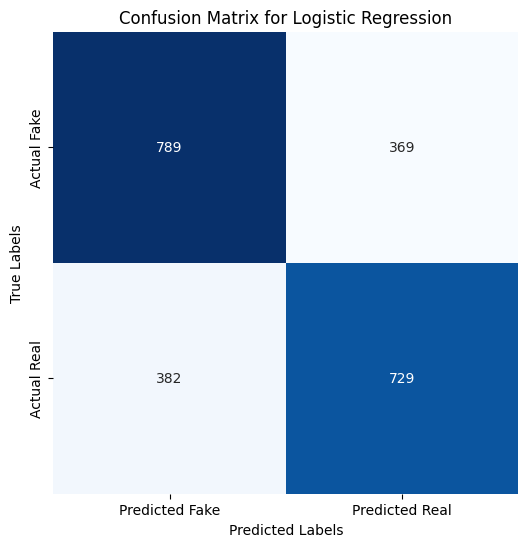

In [43]:
# prompt:  Create Confusion Matrix: This helps you visualize the accuracy of the classification by showing true positives, true negatives, false positives, and false negatives.

# Assuming 'y_test' and 'pred_lr' are defined as in your previous code
cm = confusion_matrix(y_test, pred_lr)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Fake', 'Predicted Real'],
            yticklabels=['Actual Fake', 'Actual Real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

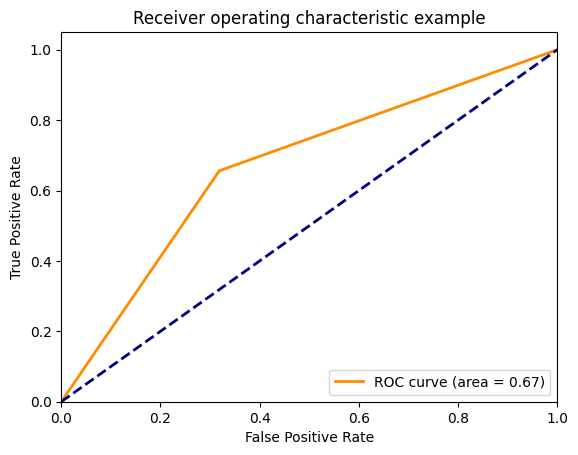

In [44]:
# prompt: create ROC Curve (Receiver Operating Characteristic): Useful for understanding the true positive rate versus the false positive rate. It’s ideal for binary classification tasks.

# Assuming y_test and pred_lr (or predictions from another model) are available.

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, pred_lr)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

An AUC of 0.67 suggests that  model performs better than random guessing but still has room for improvement.


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, pred_lr)
precision = precision_score(y_test, pred_lr)
recall = recall_score(y_test, pred_lr)
f1 = f1_score(y_test, pred_lr)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6690171881886293
Precision: 0.6639344262295082
Recall: 0.6561656165616562
F1 Score: 0.6600271616115889


**Accuracy:** 0.669 (66.9%)

 The model correctly predicts whether an article is fake or real about 66.9% of the time.

**Precision:** 0.664 (66.4%)

When the model predicts that an article is fake, it is correct about 66.4% of the time. Precision is a useful metric if false positives (real news incorrectly labeled as fake) are particularly costly or problematic.

**Recall:** 0.656 (65.6%)

 The model correctly identifies 65.6% of the actual fake news articles in the dataset. Recall is crucial if your priority is to catch as many instances of fake news as possible, even if that means occasionally mislabeling real news as fake.

**F1 Score:** 0.660 (66.0%)

 The F1 Score is the harmonic mean of precision and recall, balancing the two metrics. A score of 66.0% suggests that the model maintains a reasonable balance between correctly identifying fake news and avoiding false positives, though it indicates room for improvement.

In [47]:

news_content = str(input())


ফরিদপুরের বোয়ালমারীতে জেলা গোয়েন্দা (ডিবি) পুলিশের এক উপ-পরিদর্শকের (এসআই) বাড়িতে ঘরের দরজা ভেঙে ভেতরে ঢুকে মা ও বোনকে পিস্তল ঠেকিয়ে ডাকাতি করার অভিযোগ উঠেছে।  বুধবার (৬ নভেম্বর) বিকেলে ওই ডিবি পুলিশের মা কামরুন্নেছা এ তথ্য নিশ্চিত করেছেন।  এর আগে মঙ্গলবার (৫ নভেম্বর) রাত সাড়ে ১২টার দিকে এ ডাকাতির ঘটনা ঘটে।  উপজেলা শেখর ইউনিয়নের দরিসহস্রাইল গ্রামের বাসিন্দা ঢাকা ডিবি পুলিশে কর্মরত এসআই মো. নাসিরুদ্দিন বকুলের (৩৮) বাড়িতে এ ডাকাতি সংঘটিত হয়।  ভুক্তভোগী পরিবার সূত্রে জানা যায়, ঘরের দরজার হ্যাজবোল্ট (দরজার ছিটকানি) চাপদিয়ে ভেঙে ডাকাত দলের আট-দশজন ডাকাত ঘরে প্রবেশ করে। পরে ডিবি পুলিশের মা কামরুন্নেছার (৬৫), মাথায় পিস্তল ও তার বড় বোন মুন্নি খানমকে (৪০) ছুরি ঠেকিয়ে জিম্মি করে ডাকাতি কার্যক্রম চালায়। প্রায় তিন-চার ঘণ্টা সময় নিয়ে ডাকাতরা ঘরের ভেতরের আসবাবপত্র তল্লাশি চালিয়ে ২ লাখ ১০ হাজার টাকা ও আট-দশ ভরি স্বর্ণালংকার নিয়ে যায়।  ডিবি পুলিশের মা কামরুন্নেছা বলেন, ‘খাবার খেয়ে রাতে আমি ও আমার মেয়ে দরজার হ্যাজবোল্ট লক ও ছিটকিনি লাগিয়ে ঘুমিয়ে ছিলাম। হঠাৎ করে আট-দশজন ডাকাত ঘরের দরজা ভেঙে ভেতরে প্রব

ফরিদপুরের বোয়ালমারীতে জেলা গোয়েন্দা (ডিবি) পুলিশের এক উপ-পরিদর্শকের (এসআই) বাড়িতে ঘরের দরজা ভেঙে ভেতরে ঢুকে মা ও বোনকে পিস্তল ঠেকিয়ে ডাকাতি করার অভিযোগ উঠেছে।  

বুধবার (৬ নভেম্বর) বিকেলে ওই ডিবি পুলিশের মা কামরুন্নেছা এ তথ্য নিশ্চিত করেছেন।


এর আগে মঙ্গলবার (৫ নভেম্বর) রাত সাড়ে ১২টার দিকে এ ডাকাতির ঘটনা ঘটে।  

উপজেলা শেখর ইউনিয়নের দরিসহস্রাইল গ্রামের বাসিন্দা ঢাকা ডিবি পুলিশে কর্মরত এসআই মো. নাসিরুদ্দিন বকুলের (৩৮) বাড়িতে এ ডাকাতি সংঘটিত হয়।  

ভুক্তভোগী পরিবার সূত্রে জানা যায়, ঘরের দরজার হ্যাজবোল্ট (দরজার ছিটকানি) চাপদিয়ে ভেঙে ডাকাত দলের আট-দশজন ডাকাত ঘরে প্রবেশ করে। পরে ডিবি পুলিশের মা কামরুন্নেছার (৬৫), মাথায় পিস্তল ও তার বড় বোন মুন্নি খানমকে (৪০) ছুরি ঠেকিয়ে জিম্মি করে ডাকাতি কার্যক্রম চালায়। প্রায় তিন-চার ঘণ্টা সময় নিয়ে ডাকাতরা ঘরের ভেতরের আসবাবপত্র তল্লাশি চালিয়ে ২ লাখ ১০ হাজার টাকা ও আট-দশ ভরি স্বর্ণালংকার নিয়ে যায়।

ডিবি পুলিশের মা কামরুন্নেছা বলেন, ‘খাবার খেয়ে রাতে আমি ও আমার মেয়ে দরজার হ্যাজবোল্ট লক ও ছিটকিনি লাগিয়ে ঘুমিয়ে ছিলাম। হঠাৎ করে আট-দশজন ডাকাত ঘরের দরজা ভেঙে ভেতরে প্রবেশ করে। ডাকাতদের সবার হাতে অস্ত্র ছিল। ডাকাতদের দেখে আমি চিৎকার দিলে, আমার মাথায় পিস্তল ঠেকিয়ে, মেয়ের শয়ন কক্ষে নিয়ে মেয়েকেও জিম্মি করে ডাকাতরা। পরে আমার গলায় থাকা স্বর্ণের চেন ও কানের দুল খুলে নেয়। পরে ঘর তছনছ করে স্বর্ণালংকার টাকা ও রেশনের ১০ কেজি তেল, চিনি, আটা, ফ্রিজ থেকে ১০ কেজি মাংস নিয়ে যায় ডাকাতরা।  

ডিবি পুলিশের ভুক্তভোগী বোন মুন্নি খানম বলেন, আমার ভাই ডিবি পুলিশের এসআই নাছিরুদ্দিন বকুল। ঢাকায় আরেক ভাই বিমান বাহিনীতে চাকরি করেন। বাড়িতে আমি ও আমার মা থাকি। ডাকাতরা আমার মাকে পিস্তল ঠেকিয়ে আমার রুমে এনে আমাকেও জিম্মি করে। পরে আমার গলায় থাকা স্বর্ণের চেন, কানের দুল ভয় দেখিয়ে ছিনিয়ে নেয়। সে সময় ডাকাতরা আসবাবপত্র তছনছ করে মায়ের ক্যান্সার চিকিৎসার ২ লাখ ১০ হাজার টাকা ও আমার স্বর্ণের সাড়ে ৩ ভরি ওজনের সীতাহার, ৩ ভরি ২ রতি ওজনের স্বর্ণের চুর, পাঁচ জোড়া স্বর্ণের দুল, ও তিনটি চেন নিয়ে যায় ডাকাতরা। তারা ১০ জনের মতো ছিল।

বোয়ালমারী থানার পরিদর্শক (তদন্ত) মো. মজিবর রহমান জানান, খবর পেয়ে ঘটনাস্থল পরিদর্শন করা হয়েছে। তবে এটা চুরির ঘটনা। এখনও কেউ অভিযোগ করেননি। অভিযোগ পেলে আইনি ব্যবস্থা নেওয়া হবে।

বাংলাদেশ সময়: ২১৩৫ ঘণ্টা, নভেম্বর ০৬, ২০২৪
এসআরএস

[Bangladesh24](https://www.banglanews24.com/national/news/bd/1420564.details)


In [46]:
manual_testing(news_content)

'\n\nLR Prediction: It is a Genuine news \nDT Prediction: Fake News \nRFC Prediction: It is a Genuine news'

In [54]:
news_content = str(input())

সম্প্রতি এক গবেষণায় দাবি করা হয়েছে, বছরে মাত্র একবার আমলকি খেলে মানবদেহের সকল রোগের নিরাময় সম্ভব। এই গবেষণা পরিচালনা করেছেন কথিত বিশেষজ্ঞরা, যারা বলছেন, আমলকি খেলে ক্যান্সার, ডায়াবেটিস, হার্টের অসুখ সহ যেকোনো রোগ প্রতিরোধ করা যায়। তারা আরও জানান, শরীরের রোগপ্রতিরোধ ক্ষমতা এমনভাবে বৃদ্ধি পায় যে, পরবর্তীকালে কোনো ধরনের ঔষধের প্রয়োজন পড়বে না। ইতিমধ্যেই অনেক মানুষ এই পদ্ধতি গ্রহণ করে সুস্থ জীবনযাপন করছেন।


Fake news generated by chat gpt
সম্প্রতি এক গবেষণায় দাবি করা হয়েছে, বছরে মাত্র একবার আমলকি খেলে মানবদেহের সকল রোগের নিরাময় সম্ভব। এই গবেষণা পরিচালনা করেছেন কথিত বিশেষজ্ঞরা, যারা বলছেন, আমলকি খেলে ক্যান্সার, ডায়াবেটিস, হার্টের অসুখ সহ যেকোনো রোগ প্রতিরোধ করা যায়। তারা আরও জানান, শরীরের রোগপ্রতিরোধ ক্ষমতা এমনভাবে বৃদ্ধি পায় যে, পরবর্তীকালে কোনো ধরনের ঔষধের প্রয়োজন পড়বে না। ইতিমধ্যেই অনেক মানুষ এই পদ্ধতি গ্রহণ করে সুস্থ জীবনযাপন করছেন।

In [55]:
manual_testing(news_content)

'\n\nLR Prediction: Fake News \nDT Prediction: Fake News \nRFC Prediction: Fake News'